In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
import featuretools as ft
from feature_selector import FeatureSelector
import time
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.feature_selection import RFE
from feature_selector import FeatureSelector
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/Users/t.wang/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
/Users/t.wang/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If t

# Extract data

1. The comparison of Wrapper methods involves extracting one year data of three building from each category.
2. The best number of features are recorded for each building such that we can inform the prediction process with suitale feature numbers
3. Only one regressor is experimented
4. Only RMSE is used to judge the accuracy

In [2]:
start = time.time()

# Read meta data
meta = pd.read_csv('/Users/t.wang/Desktop/Dissertation/Python/input/meta_open.csv', 
                   index_col='uid', parse_dates=['dataend','datastart'], dayfirst=True)#The data will be messed up withou specifying dayfirst


# Read energy data
temporal = pd.read_csv('/Users/t.wang/Desktop/Dissertation/Python/input/temp_open_utc_complete.csv', 
                   index_col='timestamp', parse_dates=True)#.tz_localize('utc')

def loopModels_and_Metrics(ml_Models_names, ml_Models, weatherPoints, cor_threshold, 
                           buildingNames, agg_primitives, trans_primitives, varianceThreshold, SelectPercentile_num,
                           SelectPercentile_func, RFE_step):  
    print('\n\n' + ml_Models_names + '\n_____________')
    buildingindex = 0
    for single_building in buildingNames:
        buildingindex+=1
        print('Modelling:' + single_building)
        
        # Read energy data for each given buildingname
        single_timezone = meta.T[single_building].timezone
        startdate = meta.T[single_building].datastart
        enddate = meta.T[single_building].dataend
        single_building_energy = temporal[single_building].tz_convert(single_timezone).truncate(before = startdate, 
                                                            after = enddate)#.fillna(method='bfill').fillna(method='ffill')
                                                            # single_building_energy, some missing data


        # Get weather data for given building
        weatherfile_name = meta.T[single_building].newweatherfilename
        weather_data = pd.read_csv(os.path.join('/Users/t.wang/Desktop/Dissertation/Python/input/',
                                                weatherfile_name),index_col='timestamp', parse_dates=True, na_values='-9999')
        weather_data = weather_data.tz_localize(single_timezone, ambiguous = 'infer')
        weather_point_list=[]
        for point in weatherPoints:
            point_data = weather_data[[point]]
            weather_point_list.append(point_data)
            all_weather_point = pd.concat(weather_point_list,axis=1) #axis=1, rowwise concat
            all_weather_point = all_weather_point[~all_weather_point.index.duplicated()]#To get rid of duplicated index
            all_weather_point = all_weather_point.reindex(pd.DatetimeIndex(start = all_weather_point.index[0], 
                                                                           periods=len(single_building_energy), 
                                                                           freq='H')).fillna(method='ffill').fillna(method='bfill')
#             in some cases, there are more than 1 data in the same hour, creating more than 8760 points
#             to make them consistent, take the first index minuits, based on the number of energy data,
#             transform them into hourly data. Then we get the same number of energy data (mostly8760)
#             DatatimeIndex them, reindex then is able to match and select those hour with the minuites
#             same as first index, regulating the data to be consistent with number of energy points, get
#             rid of the repeated weather data in the same hour.
    
        # Get schedule data for given building
        schedule_name = meta.T[single_building].annualschedule
        schedule_data = pd.read_csv(os.path.join('/Users/t.wang/Desktop/Dissertation/Python/input/',
                                                schedule_name),index_col=0, header=None, parse_dates=True)
        schedule_data = schedule_data.tz_localize(single_timezone, ambiguous = 'infer')
        schedule_data.columns = ['seasonal']
        schedule_data = schedule_data.reindex(pd.DatetimeIndex(start = schedule_data.index[0], periods=len(single_building_energy), 
                                                               freq='H')).fillna(method='ffill').fillna(method='bfill')
#         same trick is applied to selecting schedule data


        
        features = pd.merge(pd.DataFrame(single_building_energy.index.tz_localize(None)), 
                    schedule_data.reset_index(drop=True), right_index=True, left_index=True)#remove the time zone information
                #Map the schedule, otherwise the TimeSplits will not be able to capture all schedules, resulting in inconsistency of traning/test feature dimensions
        features['seasonal_num'] = features.seasonal.map({'Break':0, 'Regular':1, 'Holiday':2, 'Summer':3})
        features = features.drop('seasonal', axis=1)
        features = pd.concat([features, all_weather_point.reset_index(drop=True)], axis=1) #.reset_index(drop=True) to get rid of the time index, otherwise two sets data will stratify
#                 features = features.fillna(method='ffill').fillna(method='bfill')
        # features = np.array(features)
        labels = single_building_energy.values
        '''FeatureTool'''
        es = ft.EntitySet(id = 'buildingFeatures') #create Entity set
        # create an entity from feature table, unique index is created
        es = es.entity_from_dataframe(entity_id='featureData', dataframe=features,
                      make_index=True, index='feature_id', time_index = 'timestamp')

        features_FE, feature_names = ft.dfs(entityset = es, target_entity = 'featureData', max_depth = 2
                        ,agg_primitives = agg_primitives,
                        trans_primitives = trans_primitives, verbose = True, n_jobs=1) #Not sure why n_jobs more than 1 is not working

        # one hot encoding for categorical data
        features_enc, feature_names_enc = ft.encode_features(features_FE, feature_names)
        # Replace infinity number arising after feature generation
        features_enc = features_enc.replace(np.inf, '9999')
        features_enc = features_enc.replace(-np.inf, '-9999')
        features_enc = features_enc.replace([np.nan,''],0)
#         print(features_enc)

        '''Feature Selection'''
#                 Filter methods - Remove collinear features - FeatureSelector
        y = labels
        X = features_enc
        fs = FeatureSelector(data = X, labels = y)
        fs.identify_collinear(correlation_threshold = cor_threshold, one_hot=False)
        X_collinear = fs.remove(methods = ['collinear'], keep_one_hot=False)
        
#         Filter methods - Remove features with low variance - SKlearn
        sel = VarianceThreshold(threshold=(varianceThreshold * (1 - varianceThreshold)))
        X_collinear_Variance = sel.fit_transform(X_collinear)
        X_collinear_Variance = pd.DataFrame(X_collinear_Variance)

#                 Filter methods - SelectPercentile based on mutual information - SKlearn   
        X_collinear_Variance_MI = SelectPercentile(score_func=SelectPercentile_func, percentile=SelectPercentile_num).fit_transform(X_collinear_Variance,y)
#         Extract one year data for later Wrapper methods comparison
        pd.DataFrame(X_collinear_Variance_MI).to_csv('/Users/t.wang/Desktop/Dissertation/Python/WT-result/One_year_data/'+ str(single_building)+'_One_year_features' + '.csv', index=False)
        pd.DataFrame(y).to_csv('/Users/t.wang/Desktop/Dissertation/Python/WT-result/One_year_data/'+ str(single_building)+'_One_year_target' + '.csv', index=False)
                                

    
ml_Models_lists = [['RandomForestRegressor_FE', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)]]
weatherPoints = ['TemperatureC', 'Humidity','Dew PointC','Sea Level PressurehPa', 
                 'Wind Direction','Conditions','WindDirDegrees']


chosen_buildings = [1,2,3,165,166,167,288,289,290,360,361,362,450,451,452]
#drop buildings with missing schedule
buildingNames = meta.dropna(subset=['annualschedule']).index[chosen_buildings]
    
agg_primitives = []
trans_primitives = ['weekday','hour','is_weekend','divide_numeric',
                               'and','multiply_numeric','divide_by_feature','absolute','week','subtract_numeric',
                               'percentile']
cor_threshold = 0.5
varianceThreshold = 0.8
SelectPercentile_num = 5
SelectPercentile_func = mutual_info_regression
RFE_step = 10

for elem in ml_Models_lists:
#     ml_Models_names = elem[0], ml_Models = elem[1], not sure why this gives warning 'no n_estimator'
    loopModels_and_Metrics(ml_Models_names = elem[0], ml_Models=elem[1],weatherPoints=weatherPoints,
                           buildingNames=buildingNames, cor_threshold = cor_threshold,
                           agg_primitives=agg_primitives, trans_primitives=trans_primitives,varianceThreshold=varianceThreshold,
                           SelectPercentile_num=SelectPercentile_num, SelectPercentile_func=SelectPercentile_func, RFE_step=RFE_step)

end = time.time()
elapsed = end - start 
print('Time per building after FE and FS:'+ time.strftime("%H:%M:%S", time.gmtime(elapsed)))


# all_weather_point
# schedule_data
# single_building_energy
# train_test_list
# X_train,y_train
# X_train.shape,y_train.shape
# X_test,y_test
# X_test.shape,y_test.shape
# buildingNames




RandomForestRegressor_FE
_____________
Modelling:Office_Abigail
Built 2811 features
Elapsed: 00:28 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 10/10 chunks
1177 features with a correlation magnitude greater than 0.50.

Data has not been one-hot encoded
Removed 1177 features including one-hot features.
Modelling:Office_Al
Built 2811 features
Elapsed: 00:25 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 10/10 chunks
1177 features with a correlation magnitude greater than 0.50.

Data has not been one-hot encoded
Removed 1177 features including one-hot features.
Modelling:Office_Alannah
Built 2811 features
Elapsed: 00:24 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 10/10 chunks
1177 features with a correlation magnitude greater than 0.50.

Data has not been one-hot encoded
Removed 1177 features including one-hot features.
Modelling:PrimClass_Jamie
Built 2811 features
Elapsed: 00:25 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 10/

# Wrapper methods comparison SFS

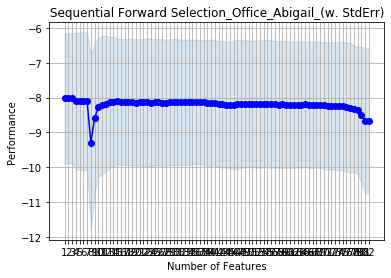

Best_score_Office_Abigail_-8.018380817542358
Best_score_rmse_Office_Abigail_2.8316745606694207
Best_features_index_(35,)
Time for selecting optimal features:05:49:36



STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

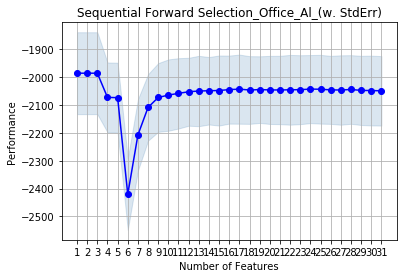

Best_score_Office_Al_-1985.2636880480638
Best_score_rmse_Office_Al_44.55629796165817
Best_features_index_(0,)
Time for selecting optimal features:02:06:58


In [ ]:
rf_r = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
chosen_building_names = ['Office_Abigail','Office_Al','Office_Alannah',
                         'PrimClass_Jamie','PrimClass_Jane','PrimClass_Janelle',
                         'UnivClass_Craig','UnivClass_Jadon','UnivClass_Maddison',
                         'UnivDorm_Leann','UnivDorm_Leonard','UnivDorm_Leslie',
                         'UnivLab_Lester','UnivLab_Levi','UnivLab_Lilly']
for i in chosen_building_names:
    features = pd.read_csv('/Users/t.wang/Desktop/Dissertation/Python/WT-result/One_year_data/'+ i + '_One_year_features.csv')
    target = pd.read_csv('/Users/t.wang/Desktop/Dissertation/Python/WT-result/One_year_data/'+ i + '_One_year_target.csv')
    
    start = time.time()
    sfs = SFS(rf_r, 
              k_features="parsimonious", 
              forward=True, 
              floating=False, 
              scoring='neg_mean_squared_error',
              cv=4,
              n_jobs=-1)
    sfs = sfs.fit(features, target)
    
    # Plotting the results
    fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')
    plt.title('Sequential Forward Selection_' + i + '_(w. StdErr)')
    plt.grid()
    plt.show()
    print('Best_score_'+ i + '_' +str(sfs.k_score_))
    print('Best_score_rmse_' + i + '_'  + str(np.sqrt(-sfs.k_score_)))
    print('Best_features_index_' + str(sfs.k_feature_idx_))
    end = time.time()
    elapsed = end - start 
    print('Time for selecting optimal features:'+ time.strftime("%H:%M:%S", time.gmtime(elapsed)))



# Wrapper method comparison SFFS

In [ ]:
for i in chosen_building_names:
    features = pd.read_csv('/Users/t.wang/Desktop/Dissertation/Python/WT-result/One_year_data/'+ i + '_One_year_features.csv')
    target = pd.read_csv('/Users/t.wang/Desktop/Dissertation/Python/WT-result/One_year_data/'+ i + '_One_year_target.csv')
    
    start = time.time()
    sffs = SFS(rf_r, 
              k_features="parsimonious", 
              forward=True, 
              floating=True, 
              scoring='neg_mean_squared_error',
              cv=4,
              n_jobs=-1)
    sffs = sffs.fit(features, target)
    
    # Plotting the results
    fig = plot_sfs(sffs.get_metric_dict(), kind='std_err')
    plt.title('Sequential Forward Floating Selection_' + i + '_(w. StdErr)')
    plt.grid()
    plt.show()
    print('Best_score_'+ i + '_' +str(sffs.k_score_))
    print('Best_score_rmse_' + i + '_'  + str(np.sqrt(-sffs.k_score_)))
    print('Best_features_index_' + str(sffs.k_feature_idx_))
    end = time.time()
    elapsed = end - start 
    print('Time for selecting optimal features:'+ time.strftime("%H:%M:%S", time.gmtime(elapsed)))